In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [2]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/pavle/Documents/MLAV/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list_cleaned.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list_cleaned.txt")
        elif subset == "training":
            excludes = load_list("validation_list_cleaned.txt") + load_list("testing_list_cleaned.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


['backward',
 'down',
 'forward',
 'go',
 'left',
 'off',
 'on',
 'right',
 'stop',
 'up']

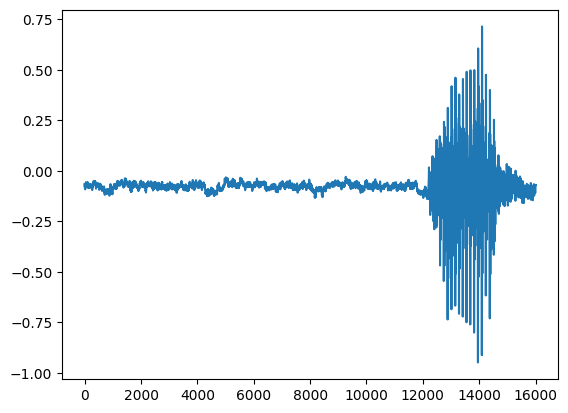

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

In [6]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [7]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [10]:
def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

In [11]:
word_start = "go"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

go --> tensor(3) --> go


In [12]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [13]:
def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

In [14]:
batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [15]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [16]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [18]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)
        losses.append(loss.item())

In [19]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        data = transform(data)
        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        pbar.update(pbar_update)
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [21]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.016666666666666666/20 [00:00<05:11, 15.57s/it]

Train Epoch: 1 [0/27013 (0%)]	Loss: 0.604416


  1%|          | 0.18333333333333332/20 [00:02<04:36, 13.97s/it] 

Train Epoch: 1 [5120/27013 (19%)]	Loss: 0.482399


  2%|▏         | 0.3416666666666669/20 [00:04<04:27, 13.62s/it] 

Train Epoch: 1 [10240/27013 (38%)]	Loss: 0.584388


  3%|▎         | 0.5250000000000006/20 [00:07<04:09, 12.82s/it] 

Train Epoch: 1 [15360/27013 (57%)]	Loss: 0.484772


  3%|▎         | 0.6833333333333333/20 [00:09<04:57, 15.38s/it]

Train Epoch: 1 [20480/27013 (75%)]	Loss: 0.532119


  4%|▍         | 0.8499999999999994/20 [00:11<04:40, 14.63s/it]

Train Epoch: 1 [25600/27013 (94%)]	Loss: 0.481039


  5%|▌         | 1.0083333333333322/20 [00:13<03:14, 10.25s/it]


Test Epoch: 1	Accuracy: 2696/3570 (76%)

Train Epoch: 2 [0/27013 (0%)]	Loss: 0.568866


  6%|▌         | 1.1833333333333316/20 [00:15<03:56, 12.58s/it]

Train Epoch: 2 [5120/27013 (19%)]	Loss: 0.433670


  7%|▋         | 1.3499999999999976/20 [00:18<04:29, 14.46s/it]

Train Epoch: 2 [10240/27013 (38%)]	Loss: 0.382859


  8%|▊         | 1.5083333333333304/20 [00:20<03:48, 12.33s/it]

Train Epoch: 2 [15360/27013 (57%)]	Loss: 0.424896


  8%|▊         | 1.6833333333333298/20 [00:22<04:50, 15.84s/it]

Train Epoch: 2 [20480/27013 (75%)]	Loss: 0.477601


  9%|▉         | 1.8499999999999959/20 [00:25<04:42, 15.56s/it]

Train Epoch: 2 [25600/27013 (94%)]	Loss: 0.388937


 10%|█         | 2.008333333333329/20 [00:27<03:30, 11.68s/it] 


Test Epoch: 2	Accuracy: 2406/3570 (67%)

Train Epoch: 3 [0/27013 (0%)]	Loss: 0.363353


 11%|█         | 2.1833333333333282/20 [00:30<04:19, 14.59s/it]

Train Epoch: 3 [5120/27013 (19%)]	Loss: 0.328232


 12%|█▏        | 2.3499999999999943/20 [00:32<05:05, 17.34s/it]

Train Epoch: 3 [10240/27013 (38%)]	Loss: 0.347701


 13%|█▎        | 2.5166666666666604/20 [00:35<04:38, 15.94s/it]

Train Epoch: 3 [15360/27013 (57%)]	Loss: 0.478912


 13%|█▎        | 2.6833333333333265/20 [00:38<04:18, 14.93s/it]

Train Epoch: 3 [20480/27013 (75%)]	Loss: 0.386392


 14%|█▍        | 2.8499999999999925/20 [00:40<03:50, 13.46s/it]

Train Epoch: 3 [25600/27013 (94%)]	Loss: 0.384325


 15%|█▍        | 2.999999999999992/20 [00:42<02:59, 10.57s/it] 


Test Epoch: 3	Accuracy: 2769/3570 (78%)

Train Epoch: 4 [0/27013 (0%)]	Loss: 0.239231


 16%|█▌        | 3.1833333333333247/20 [00:44<03:54, 13.93s/it]

Train Epoch: 4 [5120/27013 (19%)]	Loss: 0.341679


 17%|█▋        | 3.3499999999999908/20 [00:47<03:52, 13.96s/it]

Train Epoch: 4 [10240/27013 (38%)]	Loss: 0.325798


 18%|█▊        | 3.516666666666657/20 [00:49<04:27, 16.25s/it] 

Train Epoch: 4 [15360/27013 (57%)]	Loss: 0.345057


 18%|█▊        | 3.683333333333323/20 [00:52<03:29, 12.85s/it] 

Train Epoch: 4 [20480/27013 (75%)]	Loss: 0.421991


 19%|█▉        | 3.8583333333333223/20 [00:54<03:23, 12.63s/it]

Train Epoch: 4 [25600/27013 (94%)]	Loss: 0.385189


 20%|██        | 4.008333333333322/20 [00:56<02:48, 10.53s/it] 


Test Epoch: 4	Accuracy: 2998/3570 (84%)

Train Epoch: 5 [0/27013 (0%)]	Loss: 0.259803


 21%|██        | 4.183333333333331/20 [00:58<03:30, 13.29s/it]

Train Epoch: 5 [5120/27013 (19%)]	Loss: 0.439357


 22%|██▏       | 4.350000000000006/20 [01:00<03:50, 14.72s/it]

Train Epoch: 5 [10240/27013 (38%)]	Loss: 0.307767


 23%|██▎       | 4.516666666666681/20 [01:03<03:48, 14.78s/it]

Train Epoch: 5 [15360/27013 (57%)]	Loss: 0.353898


 23%|██▎       | 4.683333333333356/20 [01:05<03:28, 13.64s/it] 

Train Epoch: 5 [20480/27013 (75%)]	Loss: 0.308694


 24%|██▍       | 4.850000000000031/20 [01:07<03:29, 13.85s/it] 

Train Epoch: 5 [25600/27013 (94%)]	Loss: 0.326006


 25%|██▌       | 5.008333333333372/20 [01:09<02:47, 11.17s/it] 


Test Epoch: 5	Accuracy: 3038/3570 (85%)

Train Epoch: 6 [0/27013 (0%)]	Loss: 0.249537


 26%|██▌       | 5.183333333333381/20 [01:12<03:18, 13.42s/it]

Train Epoch: 6 [5120/27013 (19%)]	Loss: 0.364381


 27%|██▋       | 5.350000000000056/20 [01:14<04:02, 16.53s/it]

Train Epoch: 6 [10240/27013 (38%)]	Loss: 0.383646


 28%|██▊       | 5.516666666666731/20 [01:17<03:25, 14.17s/it]

Train Epoch: 6 [15360/27013 (57%)]	Loss: 0.338712


 28%|██▊       | 5.6833333333334055/20 [01:19<03:08, 13.18s/it]

Train Epoch: 6 [20480/27013 (75%)]	Loss: 0.291282


 29%|██▉       | 5.8500000000000805/20 [01:21<03:01, 12.81s/it]

Train Epoch: 6 [25600/27013 (94%)]	Loss: 0.393557


 30%|███       | 6.008333333333422/20 [01:23<02:21, 10.08s/it] 


Test Epoch: 6	Accuracy: 3045/3570 (85%)

Train Epoch: 7 [0/27013 (0%)]	Loss: 0.254413


 31%|███       | 6.18333333333343/20 [01:25<02:56, 12.77s/it] 

Train Epoch: 7 [5120/27013 (19%)]	Loss: 0.280045


 32%|███▏      | 6.350000000000105/20 [01:27<03:08, 13.84s/it]

Train Epoch: 7 [10240/27013 (38%)]	Loss: 0.331772


 33%|███▎      | 6.51666666666678/20 [01:30<02:53, 12.88s/it]  

Train Epoch: 7 [15360/27013 (57%)]	Loss: 0.362945


 33%|███▎      | 6.683333333333455/20 [01:32<03:03, 13.78s/it] 

Train Epoch: 7 [20480/27013 (75%)]	Loss: 0.395639


 34%|███▍      | 6.85000000000013/20 [01:34<03:02, 13.90s/it]  

Train Epoch: 7 [25600/27013 (94%)]	Loss: 0.367248


 35%|███▌      | 7.008333333333471/20 [01:36<02:21, 10.87s/it] 


Test Epoch: 7	Accuracy: 2970/3570 (83%)

Train Epoch: 8 [0/27013 (0%)]	Loss: 0.226348


 36%|███▌      | 7.18333333333348/20 [01:38<02:57, 13.87s/it] 

Train Epoch: 8 [5120/27013 (19%)]	Loss: 0.373379


 37%|███▋      | 7.350000000000155/20 [01:41<02:55, 13.91s/it]

Train Epoch: 8 [10240/27013 (38%)]	Loss: 0.296397


 38%|███▊      | 7.51666666666683/20 [01:43<03:04, 14.81s/it]  

Train Epoch: 8 [15360/27013 (57%)]	Loss: 0.319691


 38%|███▊      | 7.683333333333505/20 [01:46<02:51, 13.91s/it] 

Train Epoch: 8 [20480/27013 (75%)]	Loss: 0.197876


 39%|███▉      | 7.85000000000018/20 [01:48<02:43, 13.48s/it]  

Train Epoch: 8 [25600/27013 (94%)]	Loss: 0.251328


 40%|████      | 8.000000000000187/20 [01:50<02:01, 10.10s/it]


Test Epoch: 8	Accuracy: 2736/3570 (77%)

Train Epoch: 9 [0/27013 (0%)]	Loss: 0.258723


 41%|████      | 8.18333333333351/20 [01:52<02:46, 14.07s/it] 

Train Epoch: 9 [5120/27013 (19%)]	Loss: 0.237235


 42%|████▏     | 8.350000000000167/20 [01:55<02:38, 13.59s/it]

Train Epoch: 9 [10240/27013 (38%)]	Loss: 0.281538


 43%|████▎     | 8.516666666666824/20 [01:57<02:27, 12.85s/it]

Train Epoch: 9 [15360/27013 (57%)]	Loss: 0.249710


 43%|████▎     | 8.683333333333481/20 [01:59<02:32, 13.48s/it]

Train Epoch: 9 [20480/27013 (75%)]	Loss: 0.305105


 44%|████▍     | 8.850000000000138/20 [02:01<02:39, 14.29s/it]

Train Epoch: 9 [25600/27013 (94%)]	Loss: 0.257690


 45%|████▌     | 9.00000000000013/20 [02:03<01:59, 10.89s/it] 


Test Epoch: 9	Accuracy: 3064/3570 (86%)

Train Epoch: 10 [0/27013 (0%)]	Loss: 0.213848


 46%|████▌     | 9.183333333333453/20 [02:06<02:23, 13.23s/it]

Train Epoch: 10 [5120/27013 (19%)]	Loss: 0.196368


 47%|████▋     | 9.35000000000011/20 [02:08<02:45, 15.53s/it] 

Train Epoch: 10 [10240/27013 (38%)]	Loss: 0.353911


 48%|████▊     | 9.516666666666767/20 [02:11<02:28, 14.20s/it]

Train Epoch: 10 [15360/27013 (57%)]	Loss: 0.300802


 48%|████▊     | 9.683333333333424/20 [02:13<02:31, 14.68s/it]

Train Epoch: 10 [20480/27013 (75%)]	Loss: 0.310557


 49%|████▉     | 9.850000000000081/20 [02:16<02:24, 14.23s/it]

Train Epoch: 10 [25600/27013 (94%)]	Loss: 0.270775


 50%|█████     | 10.000000000000073/20 [02:17<01:42, 10.27s/it]


Test Epoch: 10	Accuracy: 2948/3570 (83%)

Train Epoch: 11 [0/27013 (0%)]	Loss: 0.232241


 51%|█████     | 10.183333333333396/20 [02:20<02:25, 14.78s/it]

Train Epoch: 11 [5120/27013 (19%)]	Loss: 0.164236


 52%|█████▏    | 10.350000000000053/20 [02:22<02:20, 14.51s/it]

Train Epoch: 11 [10240/27013 (38%)]	Loss: 0.238541


 53%|█████▎    | 10.51666666666671/20 [02:25<02:14, 14.16s/it] 

Train Epoch: 11 [15360/27013 (57%)]	Loss: 0.264699


 53%|█████▎    | 10.683333333333367/20 [02:27<01:59, 12.82s/it]

Train Epoch: 11 [20480/27013 (75%)]	Loss: 0.313653


 54%|█████▍    | 10.850000000000025/20 [02:29<01:57, 12.86s/it]

Train Epoch: 11 [25600/27013 (94%)]	Loss: 0.297534


 55%|█████▌    | 11.008333333333349/20 [02:31<01:27,  9.72s/it]


Test Epoch: 11	Accuracy: 3023/3570 (85%)

Train Epoch: 12 [0/27013 (0%)]	Loss: 0.223471


 56%|█████▌    | 11.183333333333339/20 [02:33<01:59, 13.51s/it]

Train Epoch: 12 [5120/27013 (19%)]	Loss: 0.295965


 57%|█████▋    | 11.349999999999996/20 [02:36<02:00, 13.91s/it]

Train Epoch: 12 [10240/27013 (38%)]	Loss: 0.221851


 58%|█████▊    | 11.516666666666653/20 [02:38<01:59, 14.10s/it]

Train Epoch: 12 [15360/27013 (57%)]	Loss: 0.251188


 58%|█████▊    | 11.68333333333331/20 [02:40<01:58, 14.29s/it] 

Train Epoch: 12 [20480/27013 (75%)]	Loss: 0.159985


 59%|█████▉    | 11.849999999999968/20 [02:43<01:51, 13.64s/it]

Train Epoch: 12 [25600/27013 (94%)]	Loss: 0.287287


 60%|██████    | 12.008333333333292/20 [02:44<01:27, 10.95s/it]


Test Epoch: 12	Accuracy: 2964/3570 (83%)

Train Epoch: 13 [0/27013 (0%)]	Loss: 0.204858


 61%|██████    | 12.183333333333282/20 [02:47<01:47, 13.78s/it]

Train Epoch: 13 [5120/27013 (19%)]	Loss: 0.209207


 62%|██████▏   | 12.34999999999994/20 [02:49<01:42, 13.40s/it] 

Train Epoch: 13 [10240/27013 (38%)]	Loss: 0.261011


 63%|██████▎   | 12.516666666666596/20 [02:51<01:35, 12.79s/it]

Train Epoch: 13 [15360/27013 (57%)]	Loss: 0.326165


 63%|██████▎   | 12.683333333333254/20 [02:54<01:51, 15.28s/it]

Train Epoch: 13 [20480/27013 (75%)]	Loss: 0.289858


 64%|██████▍   | 12.84999999999991/20 [02:56<01:42, 14.29s/it] 

Train Epoch: 13 [25600/27013 (94%)]	Loss: 0.265397


 65%|██████▌   | 13.008333333333235/20 [02:58<01:19, 11.37s/it]


Test Epoch: 13	Accuracy: 3064/3570 (86%)

Train Epoch: 14 [0/27013 (0%)]	Loss: 0.213746


 66%|██████▌   | 13.183333333333225/20 [03:00<01:31, 13.46s/it]

Train Epoch: 14 [5120/27013 (19%)]	Loss: 0.227203


 67%|██████▋   | 13.349999999999882/20 [03:03<01:37, 14.60s/it]

Train Epoch: 14 [10240/27013 (38%)]	Loss: 0.227876


 68%|██████▊   | 13.51666666666654/20 [03:05<01:32, 14.34s/it] 

Train Epoch: 14 [15360/27013 (57%)]	Loss: 0.160502


 68%|██████▊   | 13.683333333333197/20 [03:08<01:27, 13.81s/it]

Train Epoch: 14 [20480/27013 (75%)]	Loss: 0.263283


 69%|██████▉   | 13.849999999999854/20 [03:10<01:32, 15.02s/it]

Train Epoch: 14 [25600/27013 (94%)]	Loss: 0.298268


 70%|███████   | 14.008333333333178/20 [03:12<01:01, 10.35s/it]


Test Epoch: 14	Accuracy: 2969/3570 (83%)

Train Epoch: 15 [0/27013 (0%)]	Loss: 0.251378


 71%|███████   | 14.183333333333168/20 [03:14<01:30, 15.56s/it]

Train Epoch: 15 [5120/27013 (19%)]	Loss: 0.227610


 72%|███████▏  | 14.349999999999826/20 [03:17<01:25, 15.15s/it]

Train Epoch: 15 [10240/27013 (38%)]	Loss: 0.223202


 73%|███████▎  | 14.516666666666483/20 [03:19<01:21, 14.95s/it]

Train Epoch: 15 [15360/27013 (57%)]	Loss: 0.143888


 73%|███████▎  | 14.68333333333314/20 [03:22<01:07, 12.66s/it] 

Train Epoch: 15 [20480/27013 (75%)]	Loss: 0.197581


 74%|███████▍  | 14.849999999999797/20 [03:24<01:07, 13.09s/it]

Train Epoch: 15 [25600/27013 (94%)]	Loss: 0.263624


 75%|███████▌  | 15.008333333333121/20 [03:25<00:50, 10.17s/it]


Test Epoch: 15	Accuracy: 3141/3570 (88%)

Train Epoch: 16 [0/27013 (0%)]	Loss: 0.247460


 76%|███████▌  | 15.183333333333112/20 [03:28<01:07, 14.00s/it]

Train Epoch: 16 [5120/27013 (19%)]	Loss: 0.175737


 77%|███████▋  | 15.349999999999769/20 [03:30<00:59, 12.87s/it]

Train Epoch: 16 [10240/27013 (38%)]	Loss: 0.154849


 78%|███████▊  | 15.516666666666426/20 [03:32<01:02, 13.98s/it]

Train Epoch: 16 [15360/27013 (57%)]	Loss: 0.230220


 78%|███████▊  | 15.683333333333083/20 [03:35<00:58, 13.56s/it]

Train Epoch: 16 [20480/27013 (75%)]	Loss: 0.255531


 79%|███████▉  | 15.84999999999974/20 [03:37<00:57, 13.89s/it] 

Train Epoch: 16 [25600/27013 (94%)]	Loss: 0.218125


 80%|████████  | 16.008333333333066/20 [03:39<00:44, 11.16s/it]


Test Epoch: 16	Accuracy: 3116/3570 (87%)

Train Epoch: 17 [0/27013 (0%)]	Loss: 0.190090


 81%|████████  | 16.183333333333056/20 [03:41<00:50, 13.25s/it]

Train Epoch: 17 [5120/27013 (19%)]	Loss: 0.222175


 82%|████████▏ | 16.349999999999714/20 [03:44<00:51, 14.04s/it]

Train Epoch: 17 [10240/27013 (38%)]	Loss: 0.235291


 83%|████████▎ | 16.51666666666637/20 [03:46<00:47, 13.65s/it] 

Train Epoch: 17 [15360/27013 (57%)]	Loss: 0.249174


 83%|████████▎ | 16.683333333333028/20 [03:48<00:42, 12.83s/it]

Train Epoch: 17 [20480/27013 (75%)]	Loss: 0.242927


 84%|████████▍ | 16.849999999999685/20 [03:50<00:42, 13.65s/it]

Train Epoch: 17 [25600/27013 (94%)]	Loss: 0.205697


 85%|████████▌ | 17.00833333333301/20 [03:52<00:32, 10.72s/it] 


Test Epoch: 17	Accuracy: 2765/3570 (77%)

Train Epoch: 18 [0/27013 (0%)]	Loss: 0.150920


 86%|████████▌ | 17.183333333333/20 [03:55<00:41, 14.66s/it]   

Train Epoch: 18 [5120/27013 (19%)]	Loss: 0.168002


 87%|████████▋ | 17.349999999999657/20 [03:57<00:36, 13.86s/it]

Train Epoch: 18 [10240/27013 (38%)]	Loss: 0.231570


 88%|████████▊ | 17.516666666666314/20 [03:59<00:34, 14.05s/it]

Train Epoch: 18 [15360/27013 (57%)]	Loss: 0.224698


 88%|████████▊ | 17.68333333333297/20 [04:02<00:33, 14.62s/it] 

Train Epoch: 18 [20480/27013 (75%)]	Loss: 0.271293


 89%|████████▉ | 17.84999999999963/20 [04:04<00:29, 13.95s/it] 

Train Epoch: 18 [25600/27013 (94%)]	Loss: 0.192988


 90%|█████████ | 18.008333333332953/20 [04:06<00:22, 11.16s/it]


Test Epoch: 18	Accuracy: 2956/3570 (83%)

Train Epoch: 19 [0/27013 (0%)]	Loss: 0.220968


 91%|█████████ | 18.183333333332943/20 [04:08<00:25, 14.11s/it]

Train Epoch: 19 [5120/27013 (19%)]	Loss: 0.162903


 92%|█████████▏| 18.3499999999996/20 [04:11<00:22, 13.46s/it]  

Train Epoch: 19 [10240/27013 (38%)]	Loss: 0.179505


 93%|█████████▎| 18.516666666666257/20 [04:13<00:20, 14.09s/it]

Train Epoch: 19 [15360/27013 (57%)]	Loss: 0.126360


 93%|█████████▎| 18.683333333332914/20 [04:16<00:18, 13.85s/it]

Train Epoch: 19 [20480/27013 (75%)]	Loss: 0.164421


 94%|█████████▍| 18.84999999999957/20 [04:18<00:16, 14.33s/it] 

Train Epoch: 19 [25600/27013 (94%)]	Loss: 0.141972


 95%|█████████▌| 19.008333333332896/20 [04:20<00:11, 11.17s/it]


Test Epoch: 19	Accuracy: 3210/3570 (90%)

Train Epoch: 20 [0/27013 (0%)]	Loss: 0.134938


 96%|█████████▌| 19.183333333332886/20 [04:22<00:11, 13.85s/it]

Train Epoch: 20 [5120/27013 (19%)]	Loss: 0.146921


 97%|█████████▋| 19.349999999999543/20 [04:25<00:09, 14.17s/it]

Train Epoch: 20 [10240/27013 (38%)]	Loss: 0.110364


 98%|█████████▊| 19.5166666666662/20 [04:27<00:06, 13.45s/it]  

Train Epoch: 20 [15360/27013 (57%)]	Loss: 0.172968


 98%|█████████▊| 19.683333333332858/20 [04:29<00:04, 13.92s/it]

Train Epoch: 20 [20480/27013 (75%)]	Loss: 0.187310


 99%|█████████▉| 19.849999999999515/20 [04:32<00:02, 14.08s/it]

Train Epoch: 20 [25600/27013 (94%)]	Loss: 0.111350


100%|█████████▉| 19.999999999999506/20 [04:33<00:00, 13.69s/it]


Test Epoch: 20	Accuracy: 3215/3570 (90%)



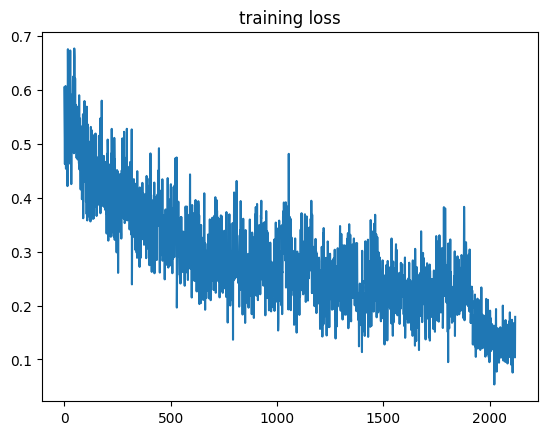

In [22]:
plt.plot(losses);
plt.title("training loss");

In [24]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

In [42]:
waveform, sample_rate, utterance, *_ = train_set
ipd.Audio(waveform.numpy(), rate=sample_rate)
print(waveform.shape)
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

torch.Size([1, 14861])
Expected: stop. Predicted: stop.


In [38]:
total = 0
incorrect = 0
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    if waveform.shape != (1, 16000):
        continue
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        incorrect += 1
    total += 1
print(incorrect / total)

Data point #9. Expected: right. Predicted: left.
Data point #17. Expected: right. Predicted: left.
Data point #133. Expected: right. Predicted: forward.
Data point #141. Expected: right. Predicted: go.
Data point #149. Expected: right. Predicted: left.
Data point #168. Expected: right. Predicted: go.
Data point #171. Expected: right. Predicted: forward.
Data point #186. Expected: right. Predicted: on.
Data point #195. Expected: right. Predicted: on.
Data point #215. Expected: right. Predicted: stop.
Data point #219. Expected: right. Predicted: left.
Data point #222. Expected: right. Predicted: forward.
Data point #234. Expected: right. Predicted: on.
Data point #237. Expected: right. Predicted: up.
Data point #273. Expected: right. Predicted: off.
Data point #280. Expected: right. Predicted: on.
Data point #283. Expected: right. Predicted: left.
Data point #294. Expected: right. Predicted: forward.
Data point #296. Expected: right. Predicted: off.
Data point #298. Expected: right. Pred

In [52]:
def load_waveform(path: str, exp_sample_rate: int):
    waveform, sample_rate = torchaudio.load(path)
    if exp_sample_rate != sample_rate:
        raise ValueError(f"sample rate should be {exp_sample_rate}, but got {sample_rate}")
    return waveform
wave = load_waveform("output.wav", 16_000)
predict(wave)

'backward'

In [53]:
m = torch.jit.script(model)
torch.jit.save(m, 'voice_recognizer.pt')